# Trafik Kazası Şiddeti Tahmin Sistemi – Akbank Makine Öğrenmesi Bootcamp Projesi
## Proje Amacı
Bu proje, Birleşik Krallık'ta meydana gelen trafik kazalarının çeşitli faktörlere göre ciddiyetini tahmin etmeyi amaçlamaktadır.
Kullanılan veri seti, UK Department for Transport tarafından yayımlanmış olan `Accidents.csv` dosyasıdır.

Hedefimiz, kazaların:
- Hangi çevresel ve trafik koşullarında daha ciddi hale geldiğini anlamak,
- `Accident_Severity` (Kaza Ciddiyeti) sınıfını tahmin eden bir makine öğrenmesi modeli geliştirmektir.
b

---



In [ ]:
# Veri işleme için temel kütüphaneler
import pandas as pd          # Veri çerçeveleriyle çalışmak için
import numpy as np           # Sayısal işlemler için

# Görselleştirme kütüphaneleri
import matplotlib.pyplot as plt   # Grafik çizmek için
import seaborn as sns             # İstatistiksel veri görselleştirmeleri için

# Modelleme ve değerlendirme
from sklearn.model_selection import train_test_split   # Veriyi eğitim/test olarak ayırmak için
from sklearn.preprocessing import LabelEncoder         # Kategorik verileri sayısallaştırmak için
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Makine öğrenmesi modelleri
from sklearn.linear_model import LogisticRegression     # Temel lineer sınıflandırma modeli
from sklearn.tree import DecisionTreeClassifier         # Karar ağacı sınıflandırma modeli
from sklearn.ensemble import RandomForestClassifier     # Ensemble (birleşik) model
from xgboost import XGBClassifier                       # Güçlü boosting tabanlı sınıflandırıcı

# Uyarıları kapatmak (temiz çıktı için)
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Makine Öğrenmesi Bootcamp

/content/drive/MyDrive/Makine Öğrenmesi Bootcamp


In [ ]:
%pwd

'/content/drive/MyDrive/Makine Öğrenmesi Bootcamp'

In [ ]:
# Veri setini yükleyelim
df = pd.read_csv("UK_Accident.csv")

# İlk 5 satırı görüntüleyerek veri setinin yapısını genel olarak inceleyelim
df.head()


,Unnamed: 0,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,...,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Year
0,0,200501BS00001,525680.0,178240.0,-0.191170,51.489096,1.0,2.0,1.0,1.0,...,Zebra crossing,Daylight: Street light present,Raining without high winds,Wet/Damp,NaN,NaN,1.0,Yes,E01002849,2005.0
1,1,200501BS00002,524170.0,181650.0,-0.211708,51.520075,1.0,3.0,1.0,1.0,...,Pedestrian phase at traffic signal junction,Darkness: Street lights present and lit,Fine without high winds,Dry,NaN,NaN,1.0,Yes,E01002909,2005.0
2,2,200501BS00003,524520.0,182240.0,-0.206458,51.525301,1.0,3.0,2.0,1.0,...,No physical crossing within 50 meters,Darkness: Street lights present and lit,Fine without high winds,Dry,NaN,NaN,1.0,Yes,E01002857,2005.0
3,3,200501BS00004,526900.0,177530.0,-0.173862,51.482442,1.0,3.0,1.0,1.0,...,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,NaN,NaN,1.0,Yes,E01002840,2005.0
4,4,200501BS00005,528060.0,179040.0,-0.156618,51.495752,1.0,3.0,1.0,1.0,...,No physical crossing within 50 meters,Darkness: Street lighting unknown,Fine without high winds,Wet/Damp,NaN,NaN,1.0,Yes,E01002863,2005.0


## EKSİK DEĞER ANALİZİ - EDA
Bu adımda veri setinin yapısını inceleyerek, eksik verileri tespit edecek ve genel veri kalitesi hakkında fikir sahibi olacağız. Ayrıca hedef değişken olan Accident_Severity'nin sınıf dağılımına da bakacağız.

In [ ]:
# Veri setinde kaç satır ve sütun olduğunu kontrol ediyoruz
print("Veri seti boyutu:", df.shape)

# Sütun isimleri, veri tipleri ve eksik değer var mı onu kontrol ediyoruz
df.info()

# Sayısal değişkenlerin temel istatistiklerine bakıyoruz
df.describe()

# Eksik değerleri kontrol ediyoruz
missing_values = df.isnull().sum()
# Eksik değer sayısı olan sütunları yazdırıyoruz
print("\nEksik değere sahip sütunlar:")
print(missing_values)


Veri seti boyutu: (34939, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34939 entries, 0 to 34938
Data columns (total 33 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Unnamed: 0                                   34939 non-null  int64  
 1   Accident_Index                               34939 non-null  object 
 2   Location_Easting_OSGR                        34925 non-null  float64
 3   Location_Northing_OSGR                       34938 non-null  float64
 4   Longitude                                    34925 non-null  float64
 5   Latitude                                     34938 non-null  float64
 6   Police_Force                                 34938 non-null  float64
 7   Accident_Severity                            34938 non-null  float64
 8   Number_of_Vehicles                           34938 non-null  float64
 9   Number_of_Casualties                      

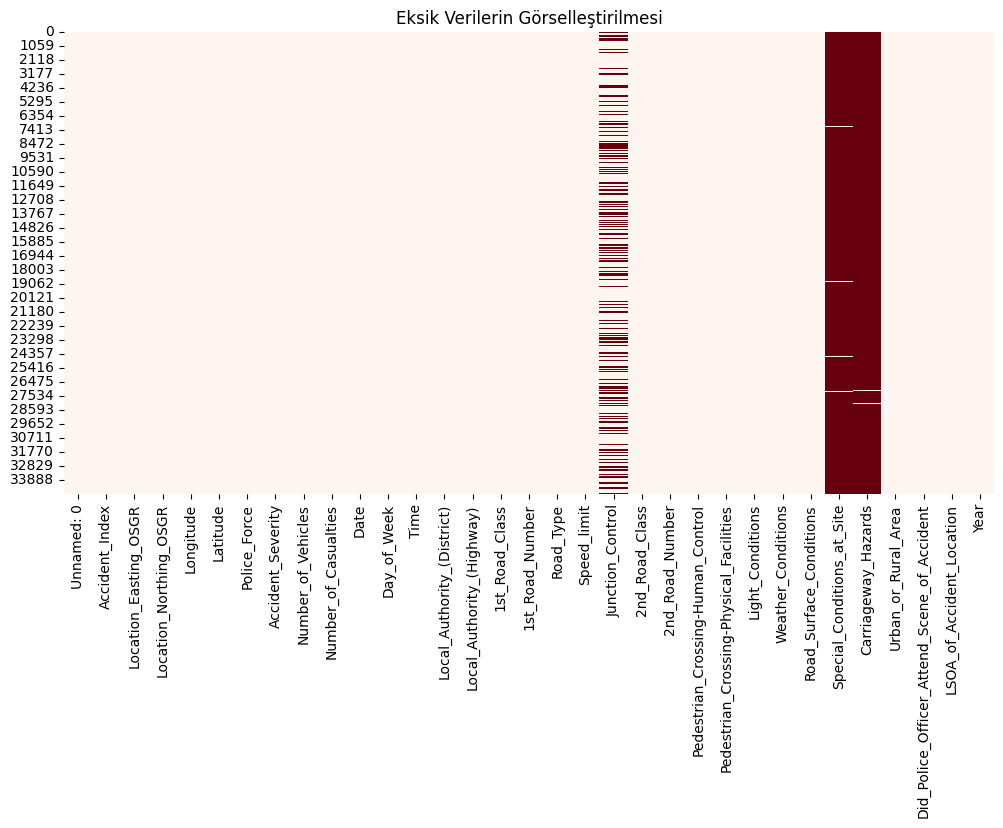

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Eksik veri görselleştirmesi (ısı haritası)
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap="Reds")
plt.title("Eksik Verilerin Görselleştirilmesi")
plt.show()


In [ ]:
# 1. Modelleme için anlamlı olmayan veya çok fazla eksik içeren sütunları siliyoruz
df.drop(columns=[
    "Unnamed: 0",                      # Sadece index sütunu
    "Accident_Index",                 # Benzersiz ID, model için anlamsız
    "Special_Conditions_at_Site",    # %98'den fazlası eksik
    "Carriageway_Hazards",           # %99'dan fazlası eksik
], inplace=True)

# 2. Kalan eksik verileri kontrol ediyoruz
print("Kalan eksik değerler:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# 3. Az sayıda eksik veri olan sütunları satır bazında silebiliriz
df.dropna(subset=[
    "Accident_Severity",
    "Light_Conditions",
    "Weather_Conditions",
    "Road_Surface_Conditions"
], inplace=True)

# 4. Orta düzeyde eksik veri içeren kategorik sütunları 'Unknown' ile doldurabiliriz
df["Junction_Control"].fillna("Unknown", inplace=True)
df["Pedestrian_Crossing-Human_Control"].fillna("Unknown", inplace=True)
df["Pedestrian_Crossing-Physical_Facilities"].fillna("Unknown", inplace=True)

# 5. Geri kalan eksik verileri de satır bazlı silebiliriz
df.dropna(inplace=True)

# Temizleme sonrası boyutu kontrol ediyoruz
print("Temizlenmiş veri seti boyutu:", df.shape)


Kalan eksik değerler:
Location_Easting_OSGR                             14
Location_Northing_OSGR                             1
Longitude                                         14
Latitude                                           1
Police_Force                                       1
Accident_Severity                                  1
Number_of_Vehicles                                 1
Number_of_Casualties                               1
Date                                               1
Day_of_Week                                        1
Time                                               2
Local_Authority_(District)                         1
Local_Authority_(Highway)                          1
1st_Road_Class                                     1
1st_Road_Number                                    1
Road_Type                                          1
Speed_limit                                        1
Junction_Control                               11345
2nd_Road_Class          

Kaza Ciddiyeti Dağılımı:
Accident_Severity
3.0    30101
2.0     4428
1.0      338
Name: count, dtype: int64

Kaza Ciddiyeti Oranları:
Accident_Severity
3.0    0.863309
2.0    0.126997
1.0    0.009694
Name: proportion, dtype: float64


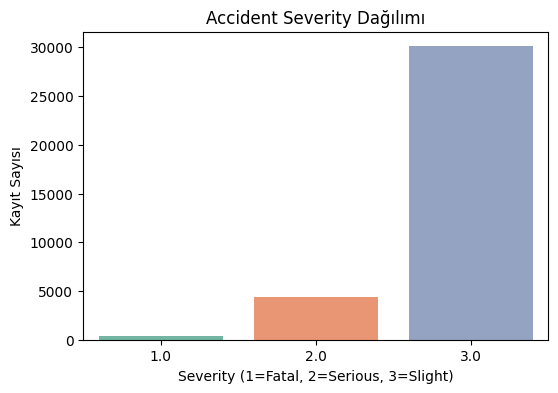

In [ ]:
# Hedef değişkenin dağılımını sayısal olarak kontrol ediyoruz
print("Kaza Ciddiyeti Dağılımı:")
print(df["Accident_Severity"].value_counts())

# Oranları da görmek faydalı olur
print("\nKaza Ciddiyeti Oranları:")
print(df["Accident_Severity"].value_counts(normalize=True))

# Bar chart ile görselleştiriyoruz
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x="Accident_Severity", data=df, palette="Set2")
plt.title("Accident Severity Dağılımı")
plt.xlabel("Severity (1=Fatal, 2=Serious, 3=Slight)")
plt.ylabel("Kayıt Sayısı")
plt.show()


veri seti dengesiz

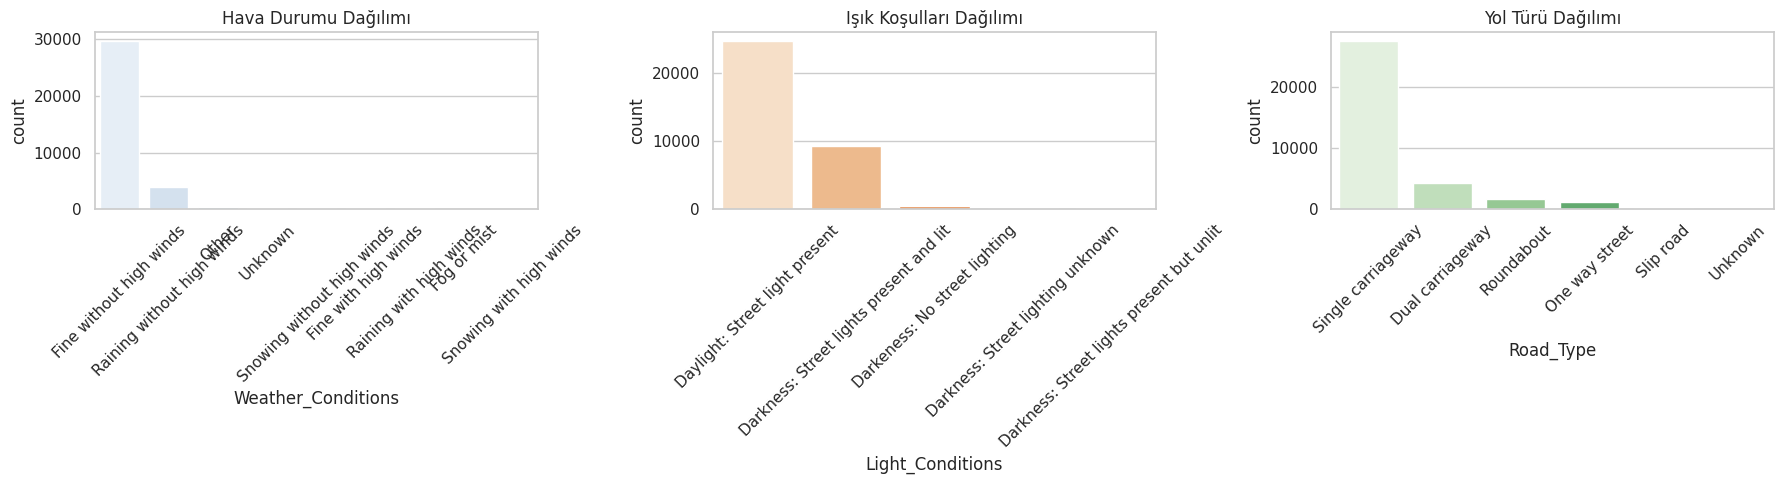

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Genel stil
sns.set(style="whitegrid")

# Figure ayarları
plt.figure(figsize=(18, 5))

# 1 - Weather_Conditions
plt.subplot(1, 3, 1)
sns.countplot(data=df, x="Weather_Conditions", order=df["Weather_Conditions"].value_counts().index, palette="Blues")
plt.title("Hava Durumu Dağılımı")
plt.xticks(rotation=45)

# 2 - Light_Conditions
plt.subplot(1, 3, 2)
sns.countplot(data=df, x="Light_Conditions", order=df["Light_Conditions"].value_counts().index, palette="Oranges")
plt.title("Işık Koşulları Dağılımı")
plt.xticks(rotation=45)

# 3 - Road_Type
plt.subplot(1, 3, 3)
sns.countplot(data=df, x="Road_Type", order=df["Road_Type"].value_counts().index, palette="Greens")
plt.title("Yol Türü Dağılımı")
plt.xticks(rotation=45)

# Tüm grafikleri göster
plt.tight_layout()
plt.show()


🌤️ Hava Durumu (Weather_Conditions)
Fine without high winds kategorisi baskın (~30.000 kayıt).
Diğer koşullar oldukça az (yağmurlu, sisli, karlı hava gibi).
Bu, kazaların çoğunun aslında "iyi hava" koşullarında gerçekleştiğini gösteriyor.
📌 Model için çıkarım: Hava koşulları tahmin için tek başına belirleyici olmayabilir. Ama yine de az rastlanan koşulların Fatal oranı yüksek olabilir (ileride hue kullanarak bakacağız).

💡 Işık Koşulları (Light_Conditions)
En fazla kaza gündüz (street light present) koşullarında gerçekleşmiş.
Ancak az sayıda da olsa ışık olmayan veya karanlık koşullar da var.
📌 Model için çıkarım: Işık koşulları, özellikle Fatal kazaları sınıflandırmakta etkili olabilir.

🛣️ Yol Türü (Road_Type)
En yaygın yol türü: Single carriageway (tek yönlü yollar).
Dual carriageway ve roundabout gibi türler çok daha az.
📌 Model için çıkarım: Yol tipi, kaza şiddetinde belirleyici bir rol oynayabilir. Daha kompleks yolların Serious ve Fatal sınıf oranı artabilir.

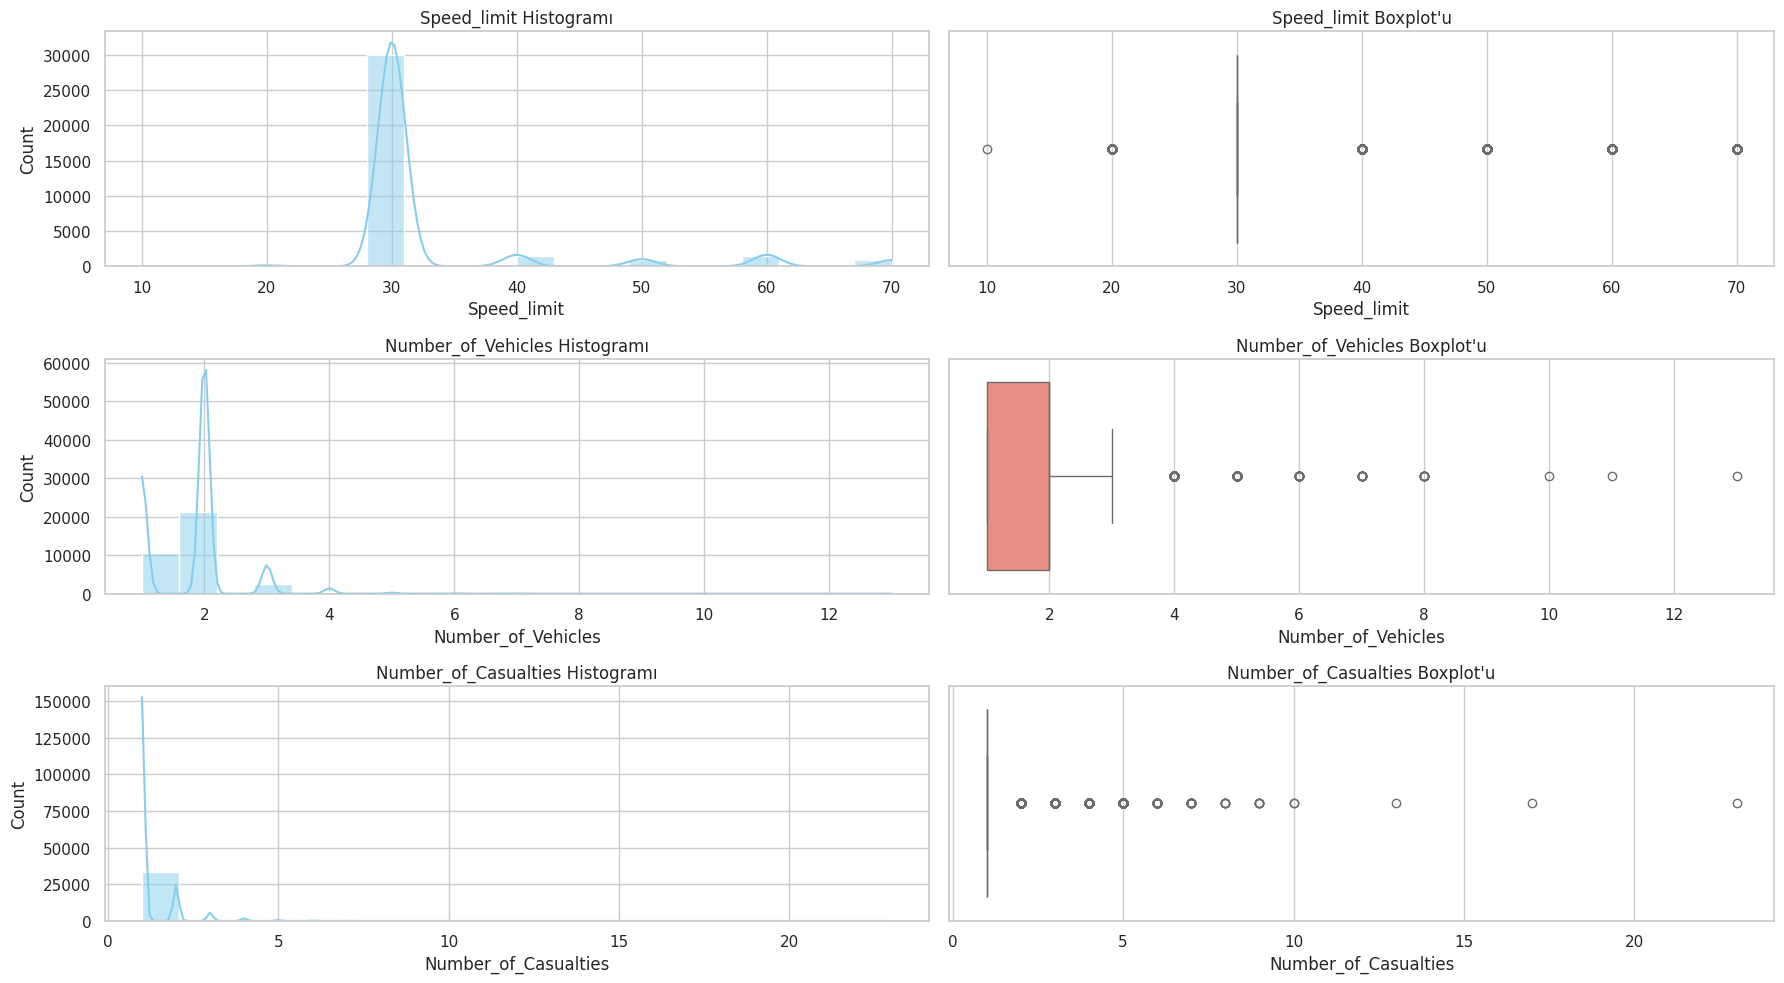

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Görselleştirme stili
sns.set(style="whitegrid")

# Sayısal sütunlar
numeric_cols = ["Speed_limit", "Number_of_Vehicles", "Number_of_Casualties"]

# Grafik çizimi
plt.figure(figsize=(18, 10))

for i, col in enumerate(numeric_cols):
    # Histogram
    plt.subplot(3, 2, i*2+1)
    sns.histplot(data=df, x=col, kde=True, bins=20, color="skyblue")
    plt.title(f"{col} Histogramı")

    # Boxplot
    plt.subplot(3, 2, i*2+2)
    sns.boxplot(data=df, x=col, color="salmon")
    plt.title(f"{col} Boxplot'u")

plt.tight_layout()
plt.show()


Number_of_Vehicles
Histogram: En yaygın sayı 2 araç.
Boxplot: 3’ten sonra aykırı değerler var.
1 araçlı kazalar da az değil.
Yorum:
Araç sayısı arttıkça kaza karmaşıklaşabilir. Ancak dağılım sağa çarpık, çoğunluk basit kazalar.

Number_of_Casualties
Histogram: Büyük çoğunluk 1 yaralı.
Boxplot: Çok sayıda aykırı değer var (10+ yaralı gibi).
Açık şekilde sağa çarpık bir dağılım.
Yorum:
Nadir ama ciddi kazalarda çok sayıda yaralanma görülüyor. Fatal sınıfla doğrudan bağlantılı olabilir.

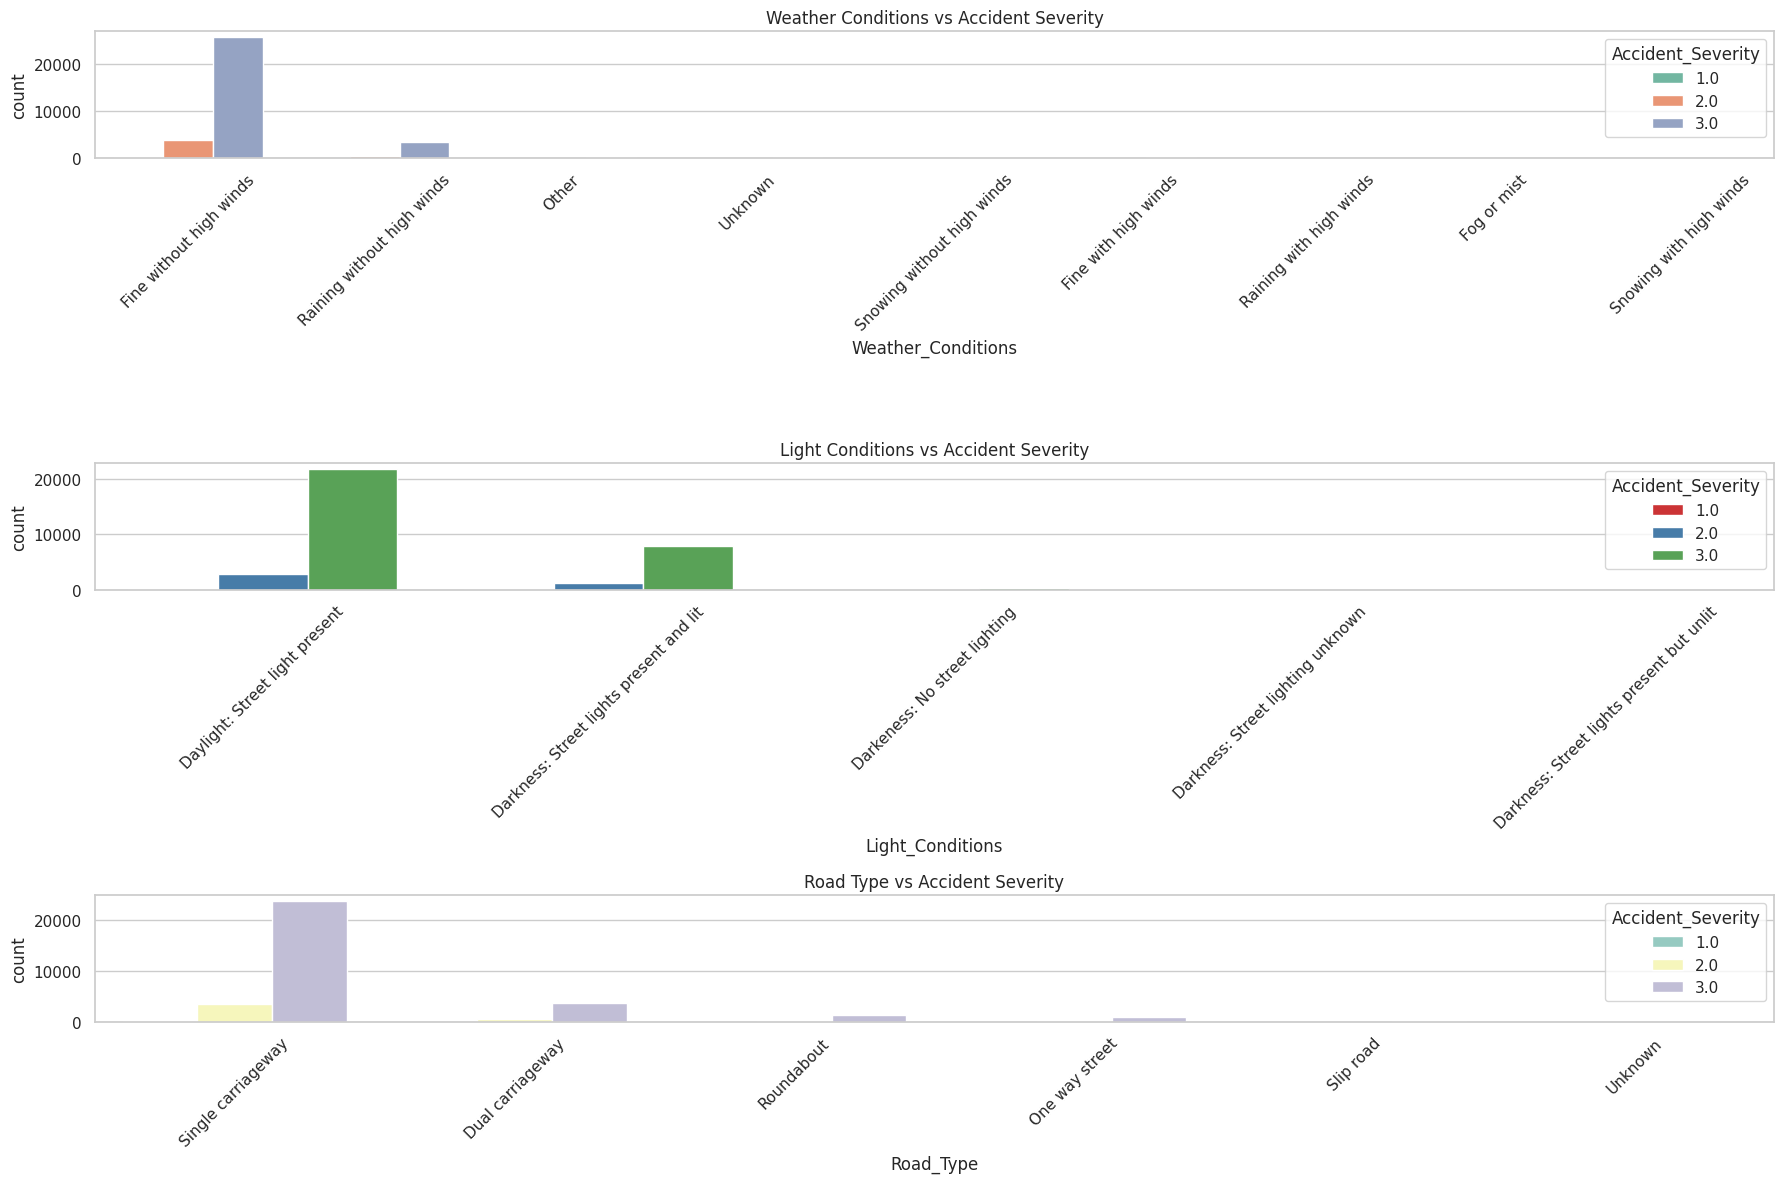

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Görselleştirme stili
sns.set(style="whitegrid")

# Boyut ayarı
plt.figure(figsize=(18, 12))

# 1 - Hava durumu ve kaza ciddiyeti
plt.subplot(3, 1, 1)
sns.countplot(data=df, x="Weather_Conditions", hue="Accident_Severity", palette="Set2",
              order=df["Weather_Conditions"].value_counts().index)
plt.title("Weather Conditions vs Accident Severity")
plt.xticks(rotation=45)

# 2 - Işık koşulları ve kaza ciddiyeti
plt.subplot(3, 1, 2)
sns.countplot(data=df, x="Light_Conditions", hue="Accident_Severity", palette="Set1",
              order=df["Light_Conditions"].value_counts().index)
plt.title("Light Conditions vs Accident Severity")
plt.xticks(rotation=45)

# 3 - Yol tipi ve kaza ciddiyeti
plt.subplot(3, 1, 3)
sns.countplot(data=df, x="Road_Type", hue="Accident_Severity", palette="Set3",
              order=df["Road_Type"].value_counts().index)
plt.title("Road Type vs Accident Severity")
plt.xticks(rotation=45)

# Grafiklerin hizalanması
plt.tight_layout()
plt.show()


Weather_Conditions vs Accident_Severity
"Fine without high winds" altında çoğunluk Slight (3) kazalar var, bu zaten bekleniyordu.
Ancak yağmurlu, sisli gibi koşullarda Serious (2) ve Fatal (1) oranları biraz daha yüksek.
"Unknown" veya çok nadir koşulların veri katkısı sınırlı.
Yorum: Hava koşulları, ciddi kazaları etkileyebilir. Rüzgar, sis gibi faktörler Fatal oranını artırıyor olabilir.

Light_Conditions vs Accident_Severity
"Daylight: Street light present" → büyük çoğunluk Slight (3) kazalar.
Karanlıkta (özellikle "No street lighting") olan kazalarda Serious (2) ve Fatal (1) oranı bariz daha fazla.
Yorum: Aydınlatma eksikliği ciddi kazalara neden olabilir. Bu değişken model için güçlü bir öznitelik.

Road_Type vs Accident_Severity
"Single carriageway" → baskın olarak Slight (3)
Ancak "Roundabout", "Dual carriageway", "One way street" gibi daha karmaşık yollarda ciddi kaza oranı artıyor.
Yorum: Yol tipi de kaza ciddiyetine etki edebilir. Özellikle kavşaklar ve tek yönlü yollar önemli olabilir.

## Veri Ön İşleme

Silinecek Sütunlar ve Gerekçeleri:
Sütun Adı	Gerekçe
Accident_Index	Benzersiz ID, model için anlam taşımıyor
LSOA_of_Accident_Location	Bölge kodu, model için anlamlı değil
Longitude, Latitude	Noktasal koordinatlar, bölge sınıfına dönüştürülmediyse anlamsız
Location_Easting_OSGR, Location_Northing_OSGR	Teknik koordinatlar, öğrenmeye katkısı yok
Date, Time, Year	Zaman bilgisi doğrudan kullanılmayacaksa çıkarılır (özellik mühendisliği yapılmadıysa)


In [ ]:
# Modelleme açısından anlamlı olmayan sütunları listeliyoruz
columns_to_drop = [
    "LSOA_of_Accident_Location",
    "Longitude",
    "Latitude",
    "Location_Easting_OSGR",
    "Location_Northing_OSGR",
    "Date",
    "Time",
    "Year"
]

# Bu sütunları veri setinden çıkarıyoruz
df.drop(columns=columns_to_drop, inplace=True)

# Kalan sütunları kontrol ediyoruz
print("Yeni sütun sayısı:", df.shape[1])
print("Kalan sütunlar:")
print(df.columns.tolist())


Yeni sütun sayısı: 21
Kalan sütunlar:
['Police_Force', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 'Day_of_Week', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident']


### Encoding

In [ ]:
# Object (metinsel) tipteki kategorik sütunları listeleyelim
categorical_cols = df.select_dtypes(include="object").columns.tolist()

print("Sayısallaştırılması gereken kategorik sütunlar:")
print(categorical_cols)


Sayısallaştırılması gereken kategorik sütunlar:
['Local_Authority_(Highway)', 'Road_Type', 'Junction_Control', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Did_Police_Officer_Attend_Scene_of_Accident']


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_enc_cols = ["Junction_Control", "Pedestrian_Crossing-Human_Control",
                  "Pedestrian_Crossing-Physical_Facilities", "Did_Police_Officer_Attend_Scene_of_Accident"]

# Her sütunu label encode edelim
le = LabelEncoder()
for col in label_enc_cols:
    df[col] = le.fit_transform(df[col])


In [ ]:
one_hot_cols = ["Weather_Conditions", "Light_Conditions", "Road_Type"]

# Bu sütunlara one-hot encoding uyguluyoruz
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)


In [ ]:
df.select_dtypes(include="object").columns.tolist()


['Local_Authority_(Highway)', 'Road_Surface_Conditions']

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Label encode edilecek sütunlar
label_enc_cols = ["Junction_Control",
                  "Pedestrian_Crossing-Human_Control",
                  "Pedestrian_Crossing-Physical_Facilities",
                  "Did_Police_Officer_Attend_Scene_of_Accident"]

le = LabelEncoder()
for col in label_enc_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encode edilecek sütunlar
one_hot_cols = ["Road_Surface_Conditions", "Local_Authority_(Highway)"]

df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

# Yeni shape’i ve kalan tipleri kontrol edelim
print("Yeni veri seti boyutu:", df.shape)
print("Kalan object tipi sütunlar:", df.select_dtypes(include='object').columns.tolist())


Yeni veri seti boyutu: (34867, 76)
Kalan object tipi sütunlar: []


In [ ]:
df.head()

,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),1st_Road_Class,1st_Road_Number,Speed_limit,Junction_Control,...,Local_Authority_(Highway)_E09000027,Local_Authority_(Highway)_E09000028,Local_Authority_(Highway)_E09000029,Local_Authority_(Highway)_E09000030,Local_Authority_(Highway)_E09000031,Local_Authority_(Highway)_E09000032,Local_Authority_(Highway)_E09000033,Local_Authority_(Highway)_E10000006,Local_Authority_(Highway)_E10000017,Local_Authority_(Highway)_EHEATHROW
0,1.0,2.0,1.0,1.0,3.0,12.0,3.0,3218.0,30.0,4,...,False,False,False,False,False,False,False,False,False,False
1,1.0,3.0,1.0,1.0,4.0,12.0,4.0,450.0,30.0,1,...,False,False,False,False,False,False,False,False,False,False
2,1.0,3.0,2.0,1.0,5.0,12.0,5.0,0.0,30.0,4,...,False,False,False,False,False,False,False,False,False,False
3,1.0,3.0,1.0,1.0,6.0,12.0,3.0,3220.0,30.0,4,...,False,False,False,False,False,False,False,False,False,False
4,1.0,3.0,1.0,1.0,2.0,12.0,6.0,0.0,30.0,4,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
from sklearn.model_selection import train_test_split

# Hedef ve özelliklerin ayrılması
X = df.drop("Accident_Severity", axis=1)
y = df["Accident_Severity"]

# Eğitim ve test verisine ayırma (%80 - %20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Boyutları kontrol etme
print("Eğitim veri seti boyutu:", X_train.shape)
print("Test veri seti boyutu:", X_test.shape)


Eğitim veri seti boyutu: (27893, 75)
Test veri seti boyutu: (6974, 75)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Kullanacağımız modeller (class_weight ayarıyla)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
}

# Sonuçları tutmak için boş bir sözlük
cv_scores = {}

# Her model için 5 katlı çapraz doğrulama yapalım
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    cv_scores[name] = scores
    print(f"{name} - Ortalama F1 (macro): {scores.mean():.4f} | Standart Sapma: {scores.std():.4f}")


Logistic Regression - Ortalama F1 (macro): 0.3255 | Standart Sapma: 0.0044
Decision Tree - Ortalama F1 (macro): 0.3473 | Standart Sapma: 0.0045
Random Forest - Ortalama F1 (macro): 0.3288 | Standart Sapma: 0.0058


Açıklamalar:
f1_macro: Her sınıfı eşit derecede önemseyerek ortalama F1 skoru hesaplar.
class_weight='balanced': Dengesiz veri sorununu azaltır.
cv=5: Veriyi 5 katlı bölerek her seferinde farklı parça ile test eder.

Kullanacağımız Model: Decision Tree Classifier

Neden Decision Tree?
F1-Macro skorlarına göre diğer modellere kıyasla en yüksek performansı verdi (0.3473).
Yorumlanabilirliği yüksek: Karar yolları ağaç yapısıyla görselleştirilebilir, "neden bu tahmini yaptı?" sorusuna cevap verebilir.
Karmaşık veri yapısına uyumlu: Sayısal ve kategorik verilerle rahat çalışır.
Dengesiz veriler için ayarlanabilir: class_weight='balanced' gibi parametrelerle azınlık sınıflar desteklenebilir.
Aykırı değerlere karşı dayanıklı ve hızlı çalışır.


Hiperparametre Optimizasyonu (GridSearchCV ile)

Amaç:
Seçtiğimiz en iyi model olan Decision Tree Classifier’ın hiperparametrelerini arayarak performansını daha da artırmak.

Optimize Edilecek Parametreler

Parametre	Açıklama
max_depth	Ağacın maksimum derinliği
min_samples_split	Bir dalın ikiye ayrılması için gereken minimum örnek sayısı
criterion	Bölme kriteri (gini, entropy)
max_features	Her split’te bakılacak maksimum özellik sayısı

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Model
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Hiperparametre arama alanı
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

# Grid Search nesnesi
grid_search = GridSearchCV(estimator=dt,
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Eğitimi başlat
grid_search.fit(X_train, y_train)

# En iyi sonuçları yazdır
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi F1-Macro skoru:", grid_search.best_score_)


Fitting 5 folds for each of 90 candidates, totalling 450 fits
En iyi parametreler: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2}
En iyi F1-Macro skoru: 0.3513583325099655


Ne Anlama Geliyor?
max_depth=None → Ağaç derinliği sınırlandırılmadı. Model veriye tam olarak uyum sağladı.
min_samples_split=2 → Bölme için en düşük sınır; en esnek yapı.
max_features='sqrt' → Her split’te karekök(k) kadar özellik değerlendirildi; bu genelde overfitting'i azaltır.
criterion='entropy' → Gini yerine bilgi kazancı (information gain) kullanıldı.
Bu parametrelerle modelin genel performansı, önceki karar ağacına göre arttı (0.347 → 0.351). Küçük ama anlamlı bir iyileştirme. ✔️

### Final Model ile Test Seti Üzerinde Değerlendirme

Amaç:
GridSearchCV ile elde ettiğimiz en iyi Decision Tree modelini test verisi üzerinde deneyip:

Gerçekçi performansını görmek
Her sınıf için precision, recall, f1-score sonuçlarını raporlamak
Confusion Matrix (karmaşıklık matrisi) ile sınıflandırma hatalarını analiz etmek


Test Seti Sınıflandırma Raporu:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        67
         2.0       0.15      0.17      0.16       886
         3.0       0.87      0.85      0.86      6021

    accuracy                           0.76      6974
   macro avg       0.34      0.34      0.34      6974
weighted avg       0.77      0.76      0.76      6974



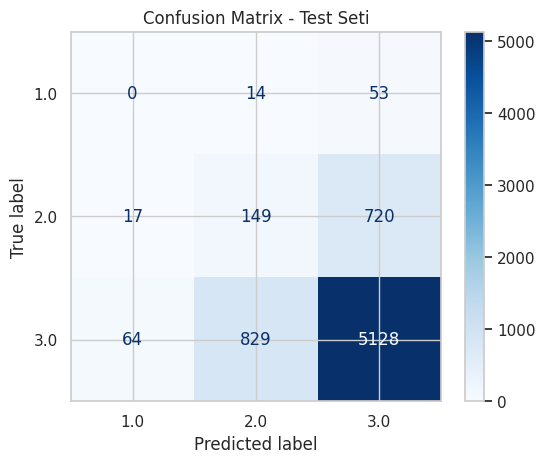

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# GridSearchCV'den en iyi modeli alıyoruz
best_model = grid_search.best_estimator_

# Test seti üzerinde tahmin yapıyoruz
y_pred = best_model.predict(X_test)

# Sınıflandırma raporunu yazdırıyoruz
print("Test Seti Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Confusion matrix oluşturuluyor
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix görselleştiriliyor (etiketleri manuel verdik)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1.0, 2.0, 3.0])
disp.plot(cmap="Blues")

plt.title("Confusion Matrix - Test Seti")
plt.show()



Veri çok dengesiz, model 3.0 sınıfına yöneliyor çünkü onu çok fazla örnekte görüyor
class_weight='balanced' uygulanmış olsa da bu yeterli olmamış
SMOTE, ADASYN, focal loss gibi teknikler düşünülmeli

Sonuç:

Bu görselle birlikte, projenin modelleme kısmını tamamlarken şunu diyebiliriz:

Model, çoğunluk sınıfı olan "Slight" sınıfını başarılı şekilde tahmin ederken, daha az temsil edilen "Fatal" ve "Serious" sınıflarında başarısız olmuştur. Bu durum, dengesiz veri seti kullanımında performans metrikleri ve veri dengeleme stratejilerinin ne kadar önemli olduğunu göstermektedir.
